<a href="https://colab.research.google.com/github/RBotL/Plant/blob/main/Final_Plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import cv2
import os

import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.image import ImageDataGenerator
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#%cd drive/MyDrive/Plant

Mounted at /content/drive


# Preparing the dataset




In [ ]:
!unzip -q "/content/drive/MyDrive/Plant/code_finalReport/New_Plant_disease_dataset.zip" -d "/content"

In [ ]:

#Fetching the images for the train set
folder_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

X_train=[]
y_train=[]

width = 80
height = 80 # resize to 80x80 to solve the RAM issue 

for path, dirs, files in os.walk(folder_path):
    for file_name in dirs:
        files_path=folder_path+file_name
        for images in os.listdir(files_path):
            img=cv2.imread(files_path+'/'+images, cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img, (width,height))
            X_train.append(np.array(img_resized)) 
            y_train.append(file_name) #plant + disease

In [ ]:
#Fetching the images for the test set
folder_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"

X_test=[]
y_test=[]

width = 80
height = 80 # resize to 80x80 to solve the RAM issue 

for path, dirs, files in os.walk(folder_path):
    for file_name in dirs:
        files_path=folder_path+file_name
        for images in os.listdir(files_path):
            img=cv2.imread(files_path+'/'+images, cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img, (width,height))
            X_test.append(np.array(img_resized))
            y_test.append(file_name) #plant + disease

In [ ]:
# Transforming the lists into arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Setting type of the data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizing the data
X_train = X_train / 255
X_test = X_test / 255


In [ ]:
# Creates a dictionary with labels and values to encode

# Gets the categories of in our dataset in a list
legends = []
for element in set(y_train):
  legends.append(element)
legends.sort() # sort the list in alphabetical order

# Creates a dictionary with the name of the category mapped to the index, as it is done when encoding with LabelEncoder
legends_dict = {k: v for k, v in enumerate(legends)}

In [ ]:
# Encoding the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_le_train = le.fit_transform(y_train)
y_le_test = le.transform(y_test)

nums = le.transform(legends)


# Plotting functions

In [ ]:
# Plotting functions

def plot_loss_accuracy(history, title=None):
    """
    Plots two graphs - loss per epoch and accuracy per epoch

    :param h
    istory: takes in a model history as a dataframe
    :param title: takes in a string for title of the plot
    """
    plt.figure(figsize=(12,4))
    plt.suptitle(title)
    plt.subplot(121)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss by epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')
    
    plt.subplot(122)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model acc by epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right');

    import itertools

def plot_cm(y_true, y_pred, title=None):
    '''
    Plots a confusion matrix

    :param y_true: takes in the true labels of the dataset
    :param y_pred: takes in the predicted labels for the dataset
    :param title: takes in a string for title of the plot
    '''
    cnf_matrix = confusion_matrix(y_true, y_pred)

    classes = range(0,38)
    plt.figure(figsize=(14, 14))


    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    #plt.yticks(nums, legends)
    plt.ylabel('Real labels')
    #plt.xticks(nums, legends,
    #                  rotation = 90)

    plt.xlabel('Predicted labels')
    plt.show()


def plot_errors(y_pred_model, y_pred_class, X, y_true):
    """
    Plots 9 random images that were labeled incorrectly

    :param y_pred_model: Takes in the the predictions generated by a model
    :param y_pred_class: Takes in the the prediction classes generated by a model
    :param X: Takes in the images
    :param y_true: Takes in the true labels of the images
    """
    plt.subplots(3, 3, figsize=(12, 14))
    plt.tight_layout()
    error_indexes = []
    map = legends_dict
    y_label = [map[i] for i in y_true]
    y_pred_label = [map[i] for i in y_pred_class]
    for i in range(len(y_pred_model)):
        if (y_pred_class[i] != y_true[i]):
          error_indexes += [i]

    j = 1
    for i in np.random.choice(error_indexes, size = 9):
        img = X[i] 
        #img = img.reshape(100, 100,3)
        
        plt.subplot(3, 3, j)
        j = j + 1
        plt.axis('off')

        plt.imshow(img,cmap = cm.binary, interpolation='None')
        plt.title('+ Label: ' +  '\n' + str(y_label[i]) \
                  + '\n' + 'Prediction: '+ '\n' +str(y_pred_label[i]) \
                  + '\n' + 'Confidence: '+  str(round(y_pred_model[i,y_pred_class[i]], 2)))



# Models

Lenet and custom

In [ ]:
# Lenet model 
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

model_le = Sequential()

model_le.add(Conv2D(filters = 126,
                     input_shape = (80,80,3),
                     kernel_size = (5,5),
                     activation = 'relu'))

model_le.add(MaxPooling2D(pool_size = (2, 2)))

model_le.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model_le.add(MaxPooling2D(pool_size = (2, 2)))

model_le.add(Dropout(rate = 0.2))

model_le.add(Flatten())

model_le.add(Dense(units = 128,
                    activation = 'relu'))

model_le.add(Dense(units = 38,
                     activation='softmax'))

model_le.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_le_history = model_le.fit(X_train, y_le_train, batch_size=32, epochs=20, validation_data=(X_test, y_le_test))

Epoch 1/20
2197/2197 [==============================] - 26s 7ms/step - loss: 1.2671 - accuracy: 0.6274 - val_loss: 0.6394 - val_accuracy: 0.8014
Epoch 2/20
2197/2197 [==============================] - 13s 6ms/step - loss: 0.5387 - accuracy: 0.8294 - val_loss: 0.4934 - val_accuracy: 0.8446
Epoch 3/20
2197/2197 [==============================] - 13s 6ms/step - loss: 0.3691 - accuracy: 0.8814 - val_loss: 0.5958 - val_accuracy: 0.8161
Epoch 4/20
2197/2197 [==============================] - 13s 6ms/step - loss: 0.2852 - accuracy: 0.9065 - val_loss: 0.4148 - val_accuracy: 0.8716
Epoch 5/20
2197/2197 [==============================] - 13s 6ms/step - loss: 0.2308 - accuracy: 0.9233 - val_loss: 0.3921 - val_accuracy: 0.8800
Epoch 6/20
2197/2197 [==============================] - 13s 6ms/step - loss: 0.1847 - accuracy: 0.9382 - val_loss: 0.4427 - val_accuracy: 0.8759
Epoch 7/20
2197/2197 [==============================] - 13s 6ms/step - loss: 0.1701 - accuracy: 0.9428 - val_loss: 0.4067 - val_ac

In [ ]:
# Saving the model 
model_storage_path = '/content/drive/MyDrive/Plant/code_finalReport/trained_models'

model_le.save(model_storage_path + '/lenet_PlantDisease')

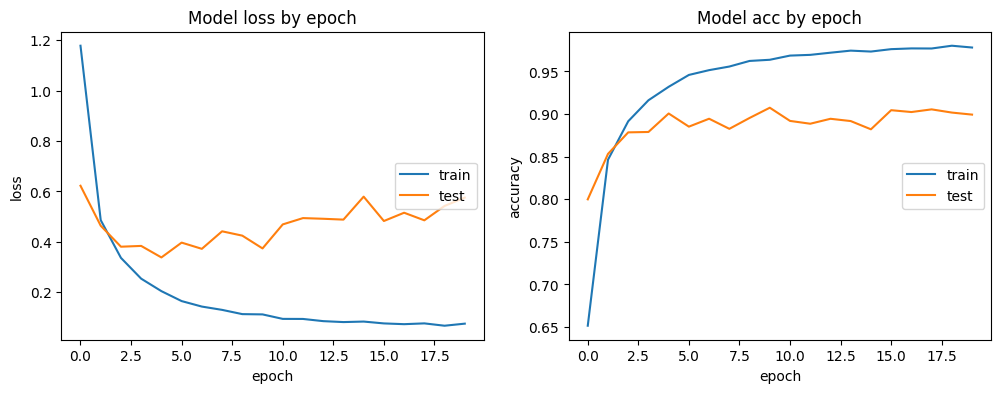

In [ ]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_le_history.history)

In [ ]:
import tensorflow as tf

# Load model 
model_path = '/content/drive/MyDrive/Plant/code_finalReport/trained_models/lenet_PlantDisease'
model_le= tf.keras.models.load_model(model_path)

In [ ]:
# Predicting the plants of the test set
y_pred_model_le = model_le.predict(X_test)

# Getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_le, axis=1)

# Classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       504
           1       0.87      0.94      0.90       497
           2       0.92      0.92      0.92       440
           3       0.87      0.87      0.87       502
           4       0.86      0.96      0.90       454
           5       0.95      0.93      0.94       421
           6       0.95      0.94      0.94       456
           7       0.84      0.89      0.86       410
           8       0.99      0.99      0.99       477
           9       0.89      0.86      0.88       477
          10       0.97      0.99      0.98       465
          11       0.87      0.94      0.90       472
          12       0.93      0.96      0.95       480
          13       0.99      0.91      0.95       430
          14       0.94      0.98      0.96       423
          15       0.98      0.95      0.96       503
          16       0.86   

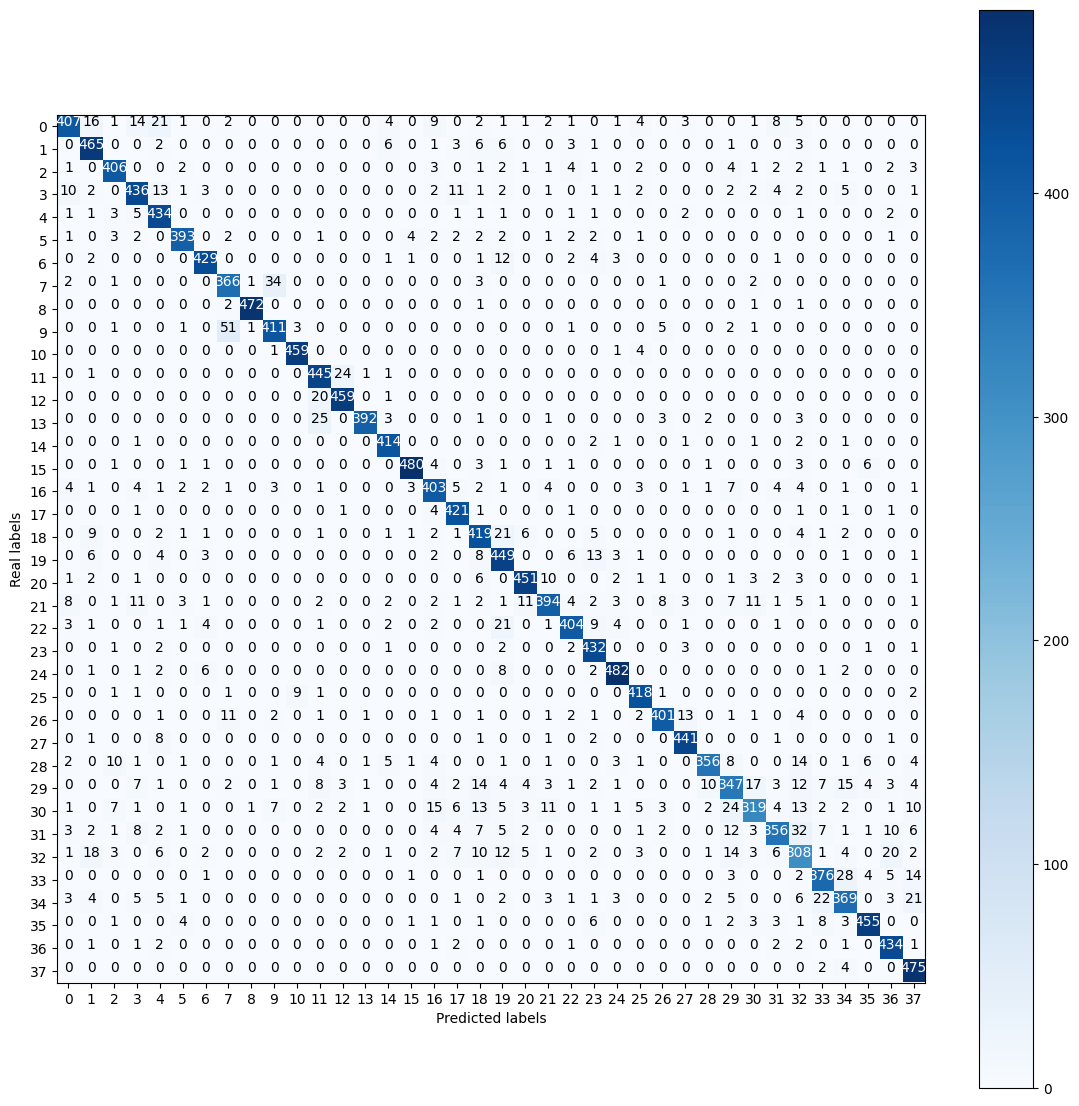

In [ ]:
# Confusion Matrix
plot_cm(y_le_test, y_pred)

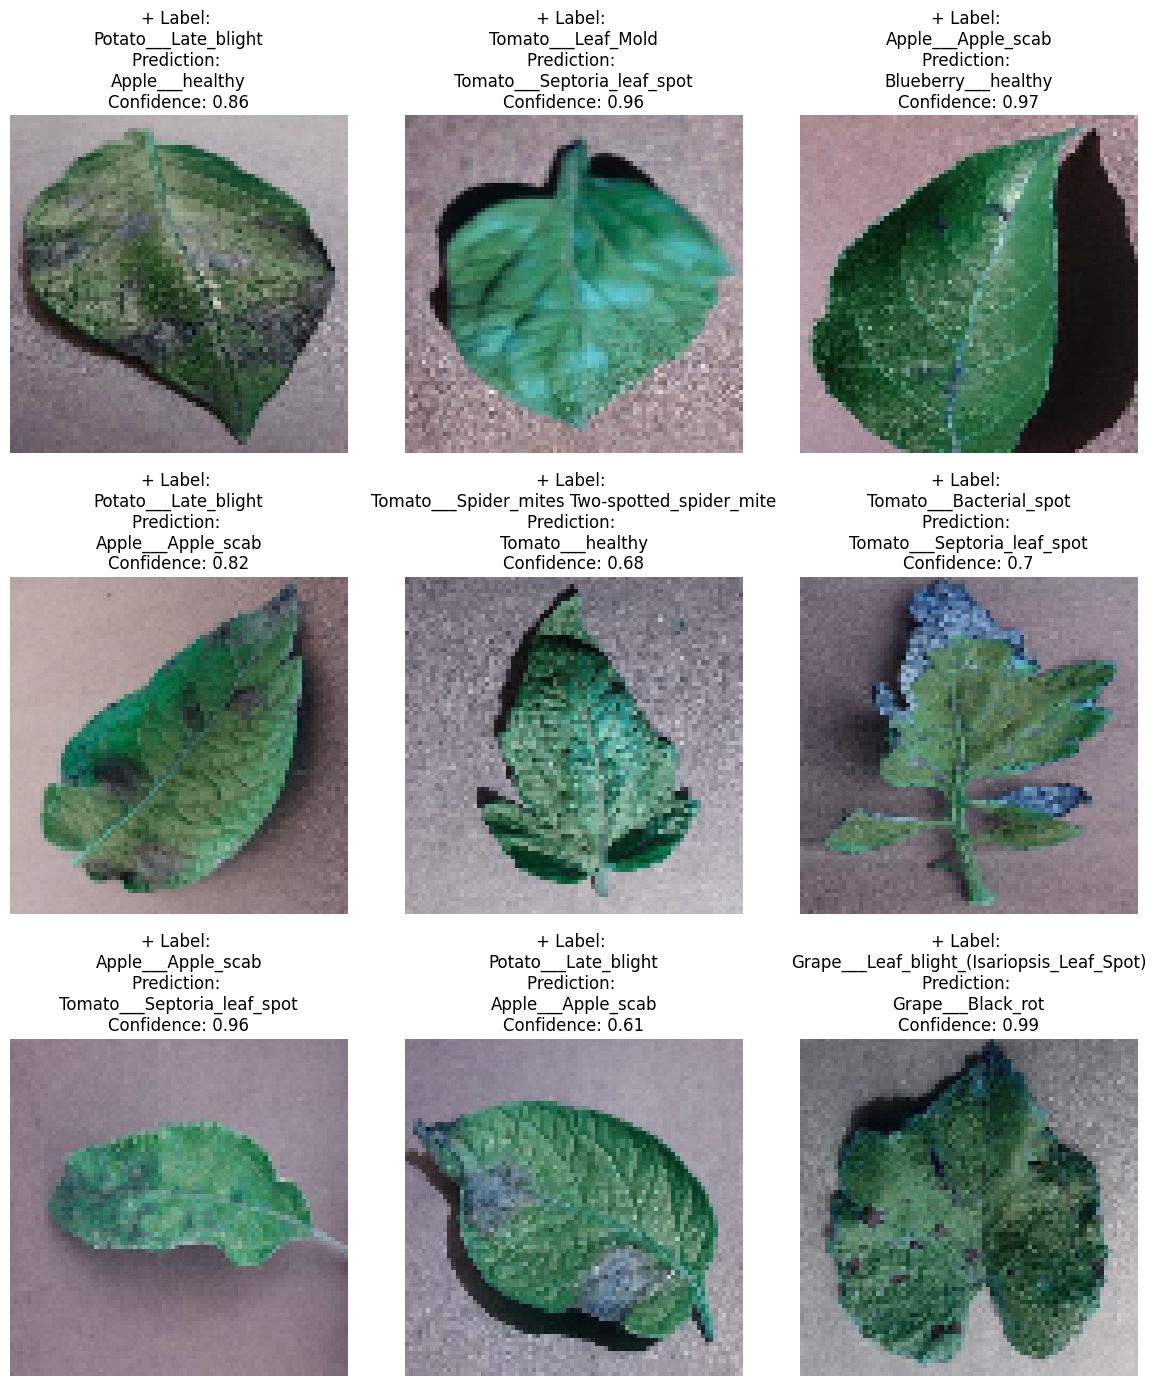

In [ ]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_le, y_pred, X_test, y_le_test)

In [ ]:
# Custom model

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
import tensorflow as tf


model_2 = Sequential()

model_2.add(Conv2D(filters=128, kernel_size=(5, 5), 
                        strides=(2, 2), activation="relu", 
                        input_shape=(80, 80, 3)))
model_2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(2048, activation="relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(38, activation="softmax"))


model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2_history = model_2.fit(X_train, y_le_train, batch_size=32, epochs=20, validation_data=(X_test, y_le_test))

Epoch 1/20
2197/2197 [==============================] - 15s 6ms/step - loss: 1.2680 - accuracy: 0.6226 - val_loss: 0.5522 - val_accuracy: 0.8244
Epoch 2/20
2197/2197 [==============================] - 11s 5ms/step - loss: 0.4769 - accuracy: 0.8448 - val_loss: 0.2843 - val_accuracy: 0.9070
Epoch 3/20
2197/2197 [==============================] - 11s 5ms/step - loss: 0.3357 - accuracy: 0.8917 - val_loss: 0.2863 - val_accuracy: 0.9071
Epoch 4/20
2197/2197 [==============================] - 11s 5ms/step - loss: 0.2579 - accuracy: 0.9149 - val_loss: 0.2301 - val_accuracy: 0.9246
Epoch 5/20
2197/2197 [==============================] - 11s 5ms/step - loss: 0.2291 - accuracy: 0.9251 - val_loss: 0.2273 - val_accuracy: 0.9293
Epoch 6/20
2197/2197 [==============================] - 11s 5ms/step - loss: 0.1995 - accuracy: 0.9354 - val_loss: 0.2771 - val_accuracy: 0.9125
Epoch 7/20
2197/2197 [==============================] - 11s 5ms/step - loss: 0.1856 - accuracy: 0.9403 - val_loss: 0.1770 - val_ac

In [ ]:
# Saving the model (best performing model)
model_storage_path = '/content/drive/MyDrive/Plant/code_finalReport/trained_models'

model_2.save(model_storage_path + '/custom_PlantDisease')

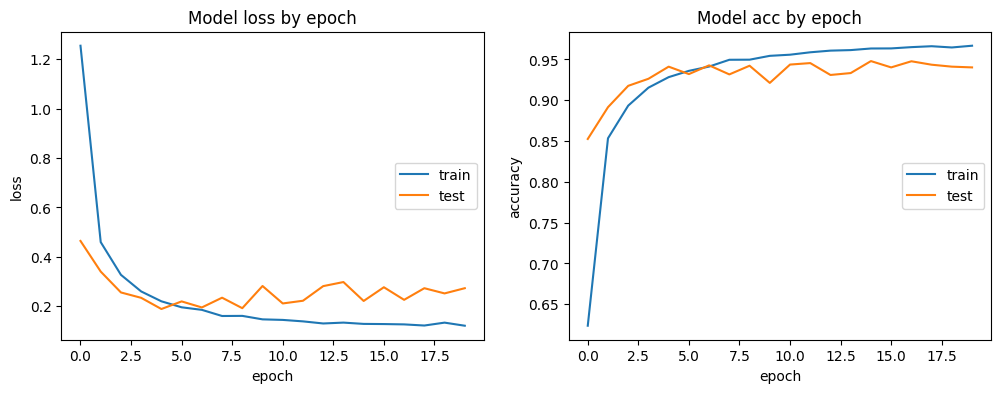

In [ ]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_2_history.history)

In [ ]:
import tensorflow as tf

# Load model 
model_path = '/content/drive/MyDrive/Plant/code_finalReport/trained_models/custom_PlantDisease'
model_2= tf.keras.models.load_model(model_path)

In [ ]:
# predicting the the plants of the test set
y_pred_model_2 = model_2.predict(X_test)

# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_2, axis=1)

# classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       504
           1       0.96      0.97      0.97       497
           2       0.95      0.95      0.95       440
           3       0.92      0.90      0.91       502
           4       0.97      0.92      0.95       454
           5       0.97      0.98      0.97       421
           6       0.98      0.99      0.98       456
           7       0.81      0.95      0.88       410
           8       0.99      1.00      0.99       477
           9       0.96      0.84      0.90       477
          10       0.99      0.98      0.99       465
          11       0.94      0.98      0.96       472
          12       0.97      0.95      0.96       480
          13       1.00      0.98      0.99       430
          14       0.99      0.99      0.99       423
          15       0.98      0.98      0.98       503
          16       0.92   

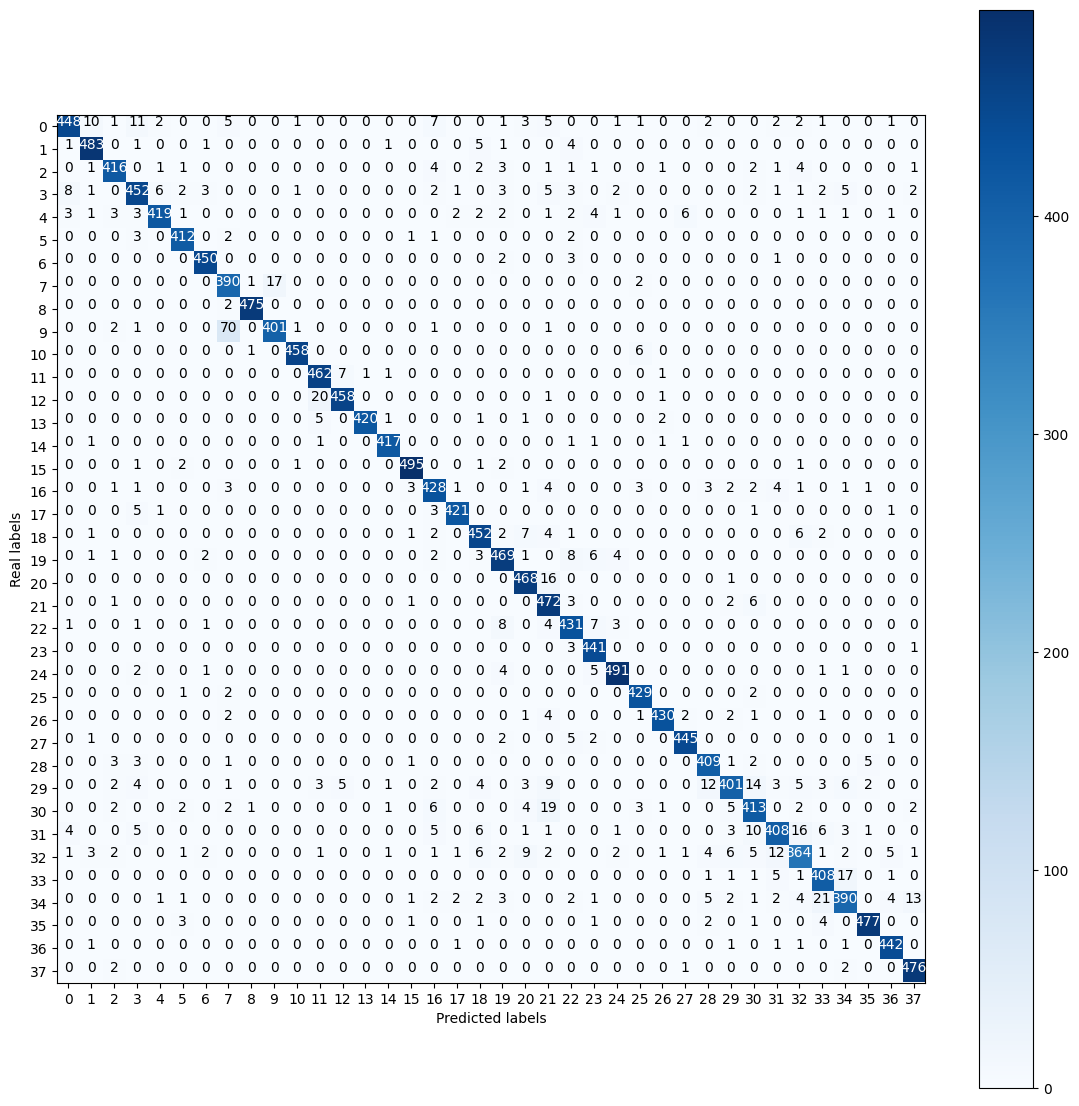

In [ ]:
# Confusion matrix
plot_cm(y_le_test, y_pred)

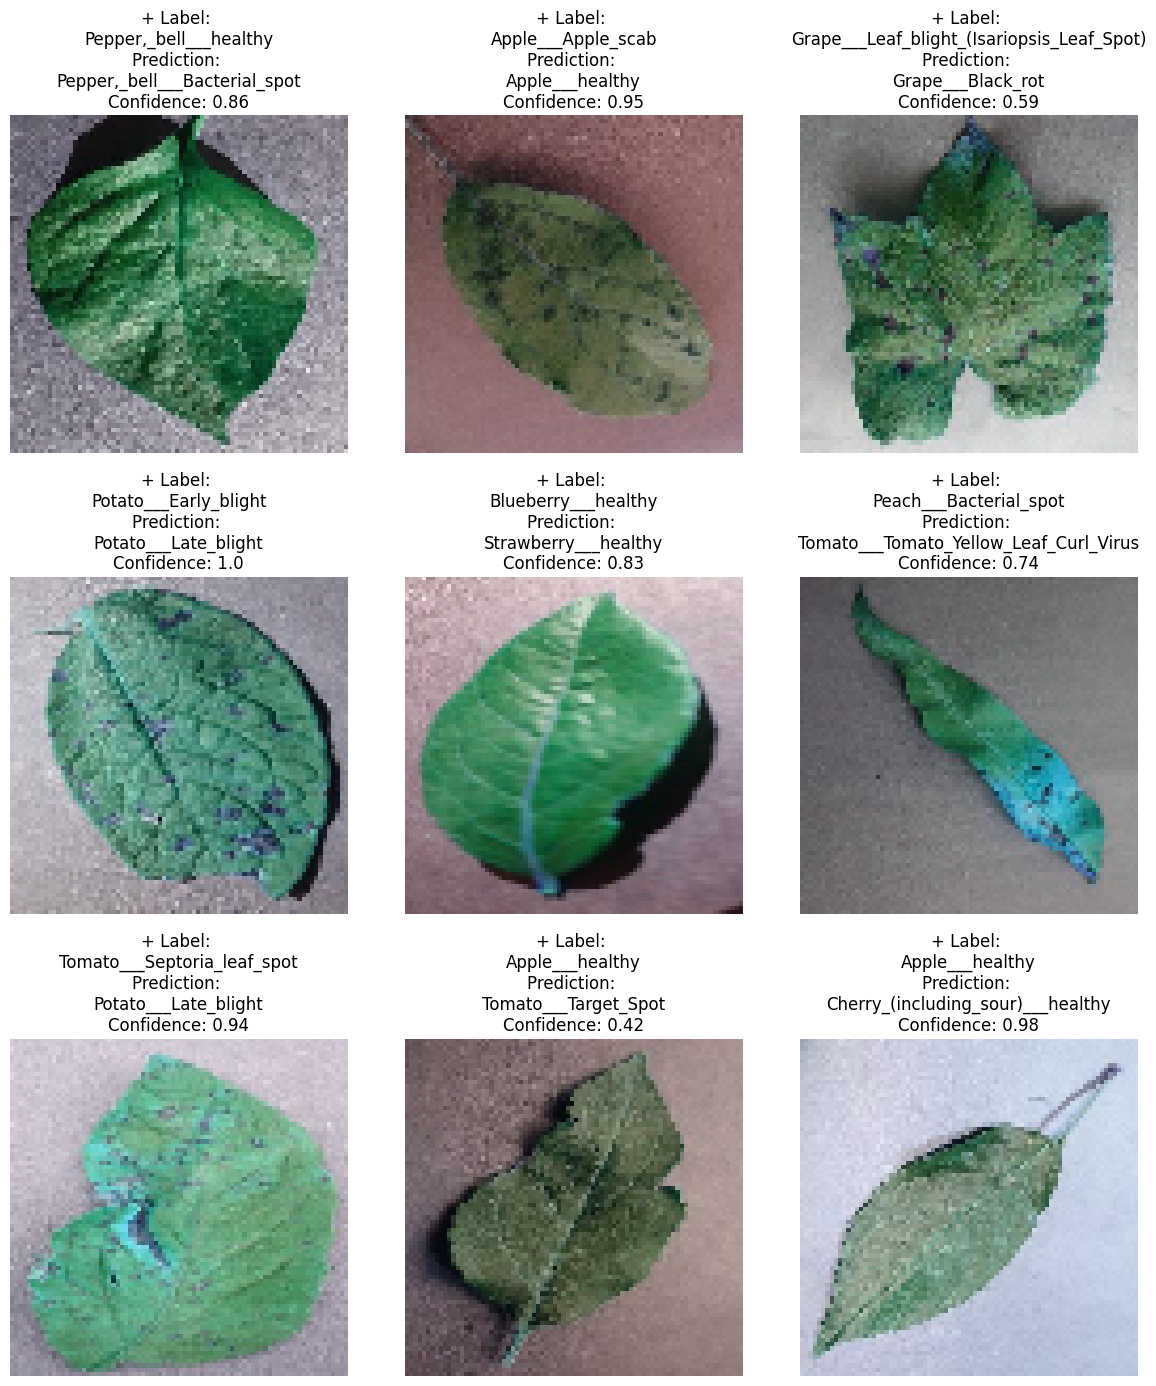

In [ ]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_2, y_pred, X_test, y_le_test)

# ImageDataGenerator

Custom model



In [ ]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.4,
        height_shift_range=0.4,
        zoom_range=[0.8, 1.2],
        horizontal_flip=True)

test_data_generator = ImageDataGenerator()

In [ ]:
# Generating data
batch_size = 64

train_data = train_data_generator.flow(X_train, y_le_train, batch_size=batch_size)
#test_data = test_data_generator.flow(X_test, y_le_test, batch_size=batch_size)

In [ ]:
# Custom model

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
import tensorflow as tf


model_2_gen = Sequential()

model_2_gen.add(Conv2D(filters=128, kernel_size=(5, 5), 
                        strides=(2, 2), activation="relu", 
                        input_shape=(80, 80, 3)))
model_2_gen.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_gen.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_gen.add(Conv2D(filters=128, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_gen.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_gen.add(Flatten())
model_2_gen.add(Dense(2048, activation="relu"))
model_2_gen.add(Dropout(0.5))
model_2_gen.add(Dense(38, activation="softmax"))


model_2_gen.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2_gen_history = model_2_gen.fit(train_data, epochs=50, validation_data=(X_test, y_le_test))

Epoch 1/50
1099/1099 [==============================] - 122s 108ms/step - loss: 2.4490 - accuracy: 0.2959 - val_loss: 1.4050 - val_accuracy: 0.5686
Epoch 2/50
1099/1099 [==============================] - 115s 105ms/step - loss: 1.3272 - accuracy: 0.5895 - val_loss: 0.9999 - val_accuracy: 0.6872
Epoch 3/50
1099/1099 [==============================] - 116s 106ms/step - loss: 1.0000 - accuracy: 0.6846 - val_loss: 0.7470 - val_accuracy: 0.7686
Epoch 4/50
1099/1099 [==============================] - 116s 106ms/step - loss: 0.8267 - accuracy: 0.7378 - val_loss: 0.6528 - val_accuracy: 0.7914
Epoch 5/50
1099/1099 [==============================] - 119s 108ms/step - loss: 0.7070 - accuracy: 0.7750 - val_loss: 0.4011 - val_accuracy: 0.8667
Epoch 6/50
1099/1099 [==============================] - 117s 106ms/step - loss: 0.6305 - accuracy: 0.7979 - val_loss: 0.3709 - val_accuracy: 0.8760
Epoch 7/50
1099/1099 [==============================] - 116s 106ms/step - loss: 0.5804 - accuracy: 0.8145 - val_

In [ ]:
# Saving the model (best performing model)
model_storage_path = '/content/drive/MyDrive/Plant/code_finalReport/trained_models'

model_2_gen.save(model_storage_path + '/custom_gen_PlantDisease')

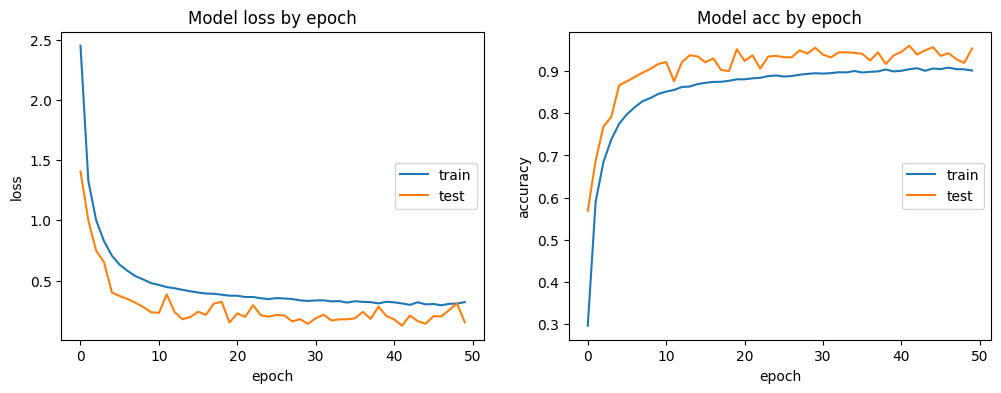

In [ ]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_2_gen_history.history)

In [ ]:
import tensorflow as tf

# Load model 
model_path = '/content/drive/MyDrive/Plant/code_finalReport/trained_models/custom_gen_PlantDisease'
model_2_gen= tf.keras.models.load_model(model_path)

In [ ]:
# predicting the the plants of the test set
y_pred_model_2_gen = model_2_gen.predict(X_test)

# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_2_gen, axis=1)

# classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       504
           1       0.98      0.98      0.98       497
           2       0.97      0.97      0.97       440
           3       0.98      0.92      0.95       502
           4       0.98      0.96      0.97       454
           5       0.99      0.97      0.98       421
           6       0.98      0.96      0.97       456
           7       0.91      0.90      0.91       410
           8       0.99      0.97      0.98       477
           9       0.94      0.96      0.95       477
          10       1.00      0.99      0.99       465
          11       0.97      0.97      0.97       472
          12       0.97      1.00      0.98       480
          13       0.97      0.96      0.96       430
          14       0.99      0.82      0.90       423
          15       0.99      0.95      0.97       503
          16       0.97   

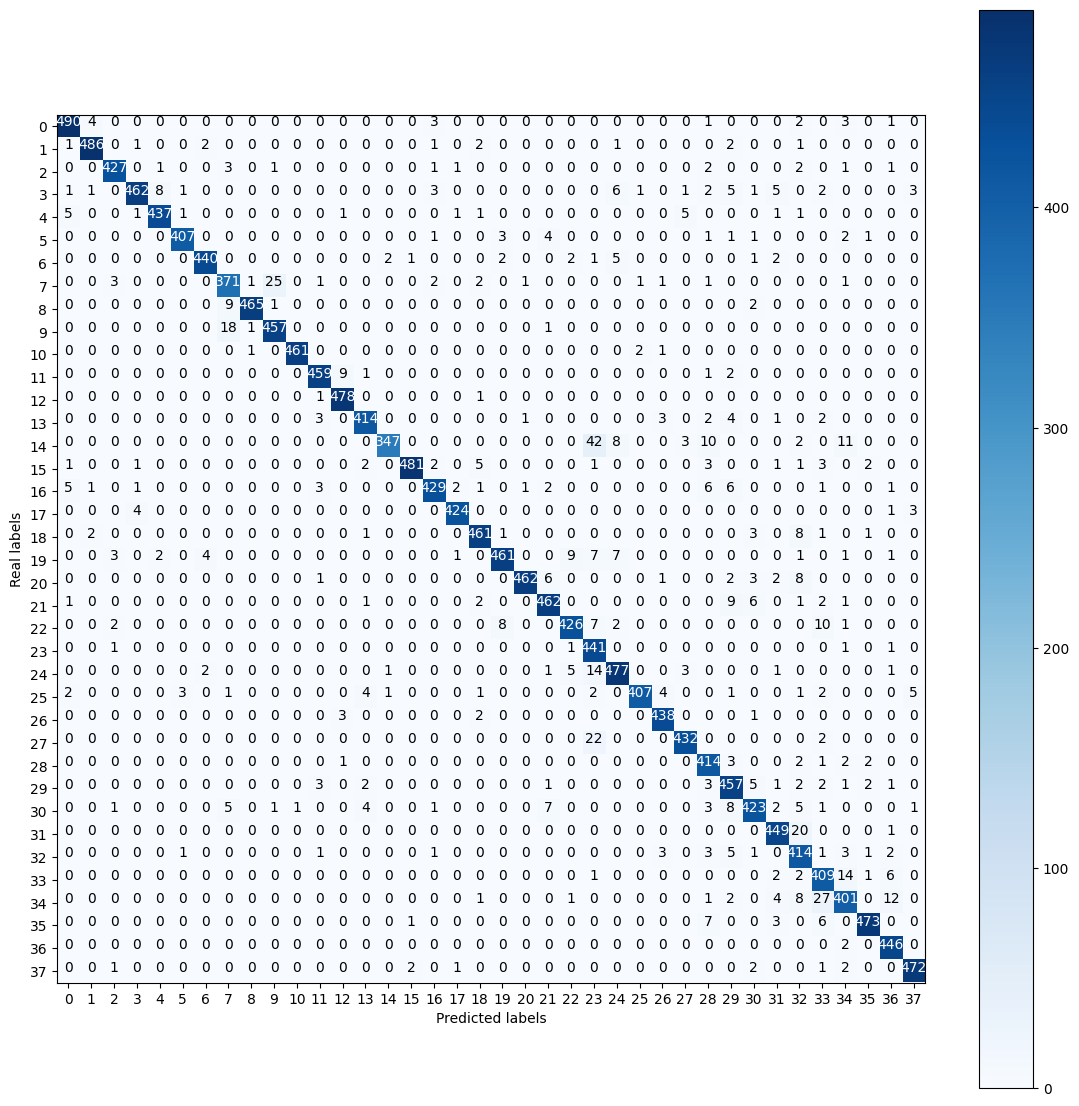

In [ ]:
# Confusion Matrix
plot_cm(y_le_test, y_pred)

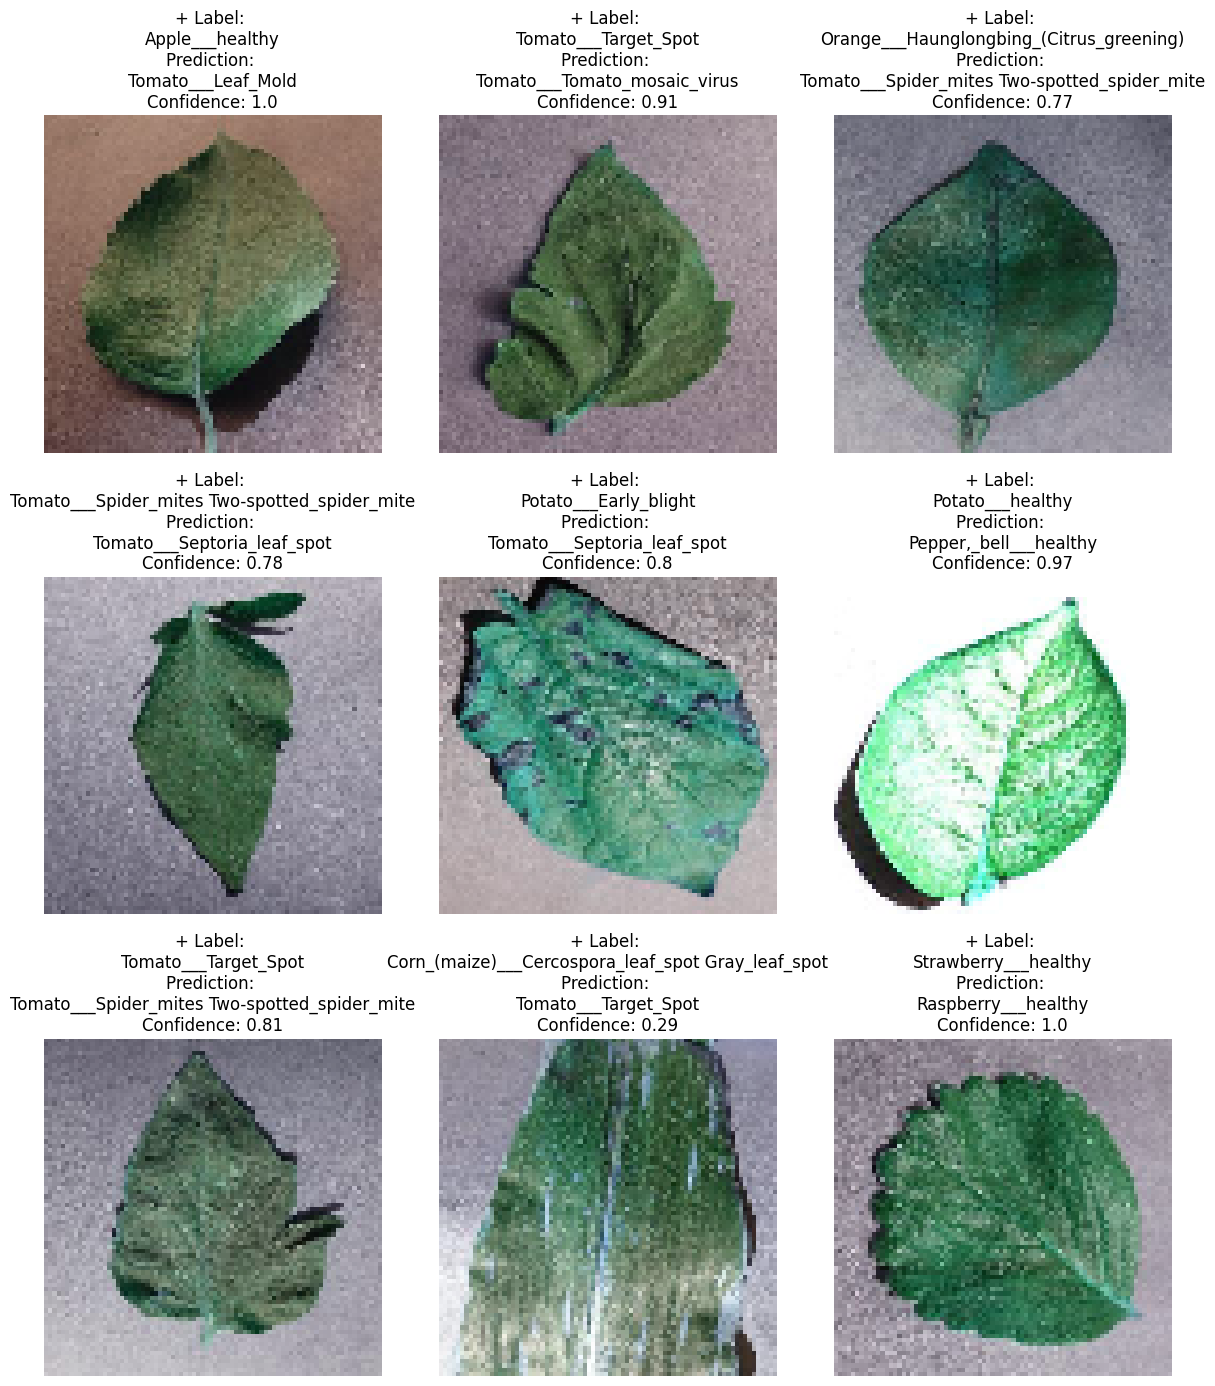

In [ ]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_2_gen, y_pred, X_test, y_le_test)

# Transfer Learning
Resnet50V2 

I run a couple of epochs of the model with: 

1.   Frozen model
2.   Last 5 layers unfrozen
3.   Last 10 layers unfrozen 
4.   Last 15 layers unfrozen


Option 3 gave the best results by far so thats what I used.
The other options are omitted in this notebook.

In [ ]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.4,
        height_shift_range=0.4,
        zoom_range=[0.8, 1.2],
        horizontal_flip=True)
test_data_generator = ImageDataGenerator(
        rescale=1./255)

train_data = train_data_generator.flow_from_directory(
        '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='sparse')
test_data = test_data_generator.flow_from_directory(
        '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
        target_size=(224, 224),
        batch_size=64,
        class_mode='sparse')



Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# Resnet50V2 model

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint

# Load the pre-trained ResNet50V2 model
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of all but the last few layers
for layer in resnet_model.layers[:-10]:
    layer.trainable = False

# Unfreeze the last few layers
for layer in resnet_model.layers[-10:]:
    layer.trainable = True

# Create a new Sequential model and add the ResNet50V2 model as the first layer
model_resnet = Sequential()
model_resnet.add(resnet_model)

# Add a custom classifier on top of the  model
model_resnet.add(Flatten())
model_resnet.add(Dense(2096, activation='relu'))
model_resnet.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
model_resnet.add(Dense(38, activation='softmax'))

# Compile the model with a categorical cross-entropy loss function and Adam optimizer
model_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saves the history of the model as a DataFrame after each epoch
csv_logger = CSVLogger("/content/drive/MyDrive/Plants/resnet_history.csv", append=True)

# Saves the weights of the model after each epoch
checkpoint_filepath = '/content/drive/MyDrive/Plants/resnet_checkpoints/cp-{epoch:04d}.ckpt'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True, verbose=1, save_freq='epoch')


model_resnet.fit(train_data,
        steps_per_epoch=train_data.samples//train_data.batch_size,
        epochs=100,
        validation_data=test_data,
        validation_steps=test_data.samples//test_data.batch_size,
        callbacks = [csv_logger, model_checkpoint])


94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/100
1098/1098 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.7250
Epoch 1: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0001.ckpt
1098/1098 [==============================] - 911s 815ms/step - loss: 0.9915 - accuracy: 0.7250 - val_loss: 0.6675 - val_accuracy: 0.8158
Epoch 2/100
1098/1098 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.8369
Epoch 2: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0002.ckpt
1098/1098 [==============================] - 948s 863ms/step - loss: 0.5235 - accuracy: 0.8369 - val_loss: 0.2850 - val_accuracy: 0.9073
Epoch 3/100
1098/1098 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.8624
Epoch 3: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0003.ckpt
1098/1098 [==============================] - 895s 815ms/step - loss: 0.4419 - accuracy: 0.8624 - val_lo

FailedPreconditionError: ignored

In [ ]:
# Resume training from where it was left off

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint

# Load the pre-trained ResNet50V2 model
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of all but the last few layers
for layer in resnet_model.layers[:-10]:
    layer.trainable = False

# Unfreeze the last few layers
for layer in resnet_model.layers[-10:]:
    layer.trainable = True

# Create a new Sequential model and add the pre-trained ResNet50V2 model as the first layer
model_resnet = Sequential()
model_resnet.add(resnet_model)

# Add a custom classifier on top of the pre-trained model
model_resnet.add(Flatten())
model_resnet.add(Dense(2096, activation='relu'))
model_resnet.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
model_resnet.add(Dense(38, activation='softmax'))

# Compile the model with a categorical cross-entropy loss function and Adam optimizer
model_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Loads the weights were the last trainig was left on
model_resnet.load_weights("/content/drive/MyDrive/Plants/resnet_checkpoints/cp-0040.ckpt")

# Saves the history of the model as a DataFrame after each epoch
csv_logger = CSVLogger("/content/drive/MyDrive/Plants/resnet_history.csv", append=True)

# Saves the weights of the model after each epoch
checkpoint_filepath = '/content/drive/MyDrive/Plants/resnet_checkpoints/cp-{epoch:04d}.ckpt'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True, verbose=1)


model_resnet.fit(train_data,
        steps_per_epoch=train_data.samples//train_data.batch_size,
        epochs=100,
        initial_epoch=40, # starts from epoch 41
        validation_data=test_data,
        validation_steps=test_data.samples//test_data.batch_size,
        callbacks = [csv_logger, model_checkpoint])


Epoch 41/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9454
Epoch 41: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0041.ckpt
1098/1098 [==============================] - 986s 860ms/step - loss: 0.1749 - accuracy: 0.9454 - val_loss: 0.0927 - val_accuracy: 0.9703
Epoch 42/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9481
Epoch 42: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0042.ckpt
1098/1098 [==============================] - 911s 830ms/step - loss: 0.1711 - accuracy: 0.9481 - val_loss: 0.1008 - val_accuracy: 0.9694
Epoch 43/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9467
Epoch 43: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0043.ckpt
1098/1098 [==============================] - 902s 822ms/step - loss: 0.1737 - accuracy: 0.9467 - val_loss: 0.1285 - val_accuracy: 0.9653
Epoch 44/100
1098/1098 [=

In [ ]:
# Resume training from where it was left off

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint

# Load the pre-trained ResNet50V2 model
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of all but the last few layers
for layer in resnet_model.layers[:-10]:
    layer.trainable = False

# Unfreeze the last few layers
for layer in resnet_model.layers[-10:]:
    layer.trainable = True

# Create a new Sequential model and add the pre-trained ResNet50V2 model as the first layer
model_resnet = Sequential()
model_resnet.add(resnet_model)

# Add a custom classifier on top of the pre-trained model
model_resnet.add(Flatten())
model_resnet.add(Dense(2096, activation='relu'))
model_resnet.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
model_resnet.add(Dense(38, activation='softmax'))

# Compile the model with a categorical cross-entropy loss function and Adam optimizer
model_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Loads the weights were the last trainig was left on
model_resnet.load_weights("/content/drive/MyDrive/Plants/resnet_checkpoints/cp-0052.ckpt")

# Saves the history of the model as a DataFrame after each epoch
csv_logger = CSVLogger("/content/drive/MyDrive/Plants/resnet_history.csv", append=True)

# Saves the weights of the model after each epoch
checkpoint_filepath = '/content/drive/MyDrive/Plants/resnet_checkpoints/cp-{epoch:04d}.ckpt'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True, verbose=1)


model_resnet.fit(train_data,
        steps_per_epoch=train_data.samples//train_data.batch_size,
        epochs=100,
        initial_epoch=52, # starts from epoch 53
        validation_data=test_data,
        validation_steps=test_data.samples//test_data.batch_size,
        callbacks = [csv_logger, model_checkpoint])



94668760/94668760 [==============================] - 0s 0us/step
Epoch 53/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9508
Epoch 53: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0053.ckpt
1098/1098 [==============================] - 994s 879ms/step - loss: 0.1591 - accuracy: 0.9508 - val_loss: 0.0970 - val_accuracy: 0.9728
Epoch 54/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9501
Epoch 54: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0054.ckpt
1098/1098 [==============================] - 904s 823ms/step - loss: 0.1569 - accuracy: 0.9501 - val_loss: 0.0887 - val_accuracy: 0.9734
Epoch 55/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9520
Epoch 55: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0055.ckpt
1098/1098 [==============================] - 918s 836ms/step - loss: 0.1553 - accuracy: 0.9520 - 

FailedPreconditionError: ignored

In [ ]:
# Resume training from where it was left off

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint

# Load the pre-trained ResNet50V2 model
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of all but the last few layers
for layer in resnet_model.layers[:-10]:
    layer.trainable = False

# Unfreeze the last few layers
for layer in resnet_model.layers[-10:]:
    layer.trainable = True

# Create a new Sequential model and add the pre-trained ResNet50V2 model as the first layer
model_resnet = Sequential()
model_resnet.add(resnet_model)

# Add a custom classifier on top of the pre-trained model
model_resnet.add(Flatten())
model_resnet.add(Dense(2096, activation='relu'))
model_resnet.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
model_resnet.add(Dense(38, activation='softmax'))

# Compile the model with a categorical cross-entropy loss function and Adam optimizer
model_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Loads the weights were the last trainig was left on
model_resnet.load_weights("/content/drive/MyDrive/Plants/resnet_checkpoints/cp-0091.ckpt")

# Saves the history of the model as a DataFrame after each epoch
csv_logger = CSVLogger("/content/drive/MyDrive/Plants/resnet_history.csv", append=True)

# Saves the weights of the model after each epoch
checkpoint_filepath = '/content/drive/MyDrive/Plants/resnet_checkpoints/cp-{epoch:04d}.ckpt'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True, verbose=1)


model_resnet.fit(train_data,
        steps_per_epoch=train_data.samples//train_data.batch_size,
        epochs=100,
        initial_epoch=91, # starts from epoch 92
        validation_data=test_data,
        validation_steps=test_data.samples//test_data.batch_size,
        callbacks = [csv_logger, model_checkpoint])



94668760/94668760 [==============================] - 5s 0us/step
Epoch 92/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9607
Epoch 92: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0092.ckpt
1098/1098 [==============================] - 978s 850ms/step - loss: 0.1287 - accuracy: 0.9607 - val_loss: 0.0716 - val_accuracy: 0.9780
Epoch 93/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9605
Epoch 93: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0093.ckpt
1098/1098 [==============================] - 886s 807ms/step - loss: 0.1283 - accuracy: 0.9605 - val_loss: 0.0917 - val_accuracy: 0.9746
Epoch 94/100
1098/1098 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.9612
Epoch 94: saving model to /content/drive/MyDrive/Plants/resnet_checkpoints/cp-0094.ckpt
1098/1098 [==============================] - 879s 800ms/step - loss: 0.1265 - accuracy: 0.9612 - 

In [ ]:
# Save the model
model_storage_path = '/content/drive/MyDrive/Plants/model'

model_resnet.save(model_storage_path + '/resnet_disease')

In [ ]:
# read the model history
df = pd.read_csv('/content/drive/MyDrive/Plants/resnet_history.csv')

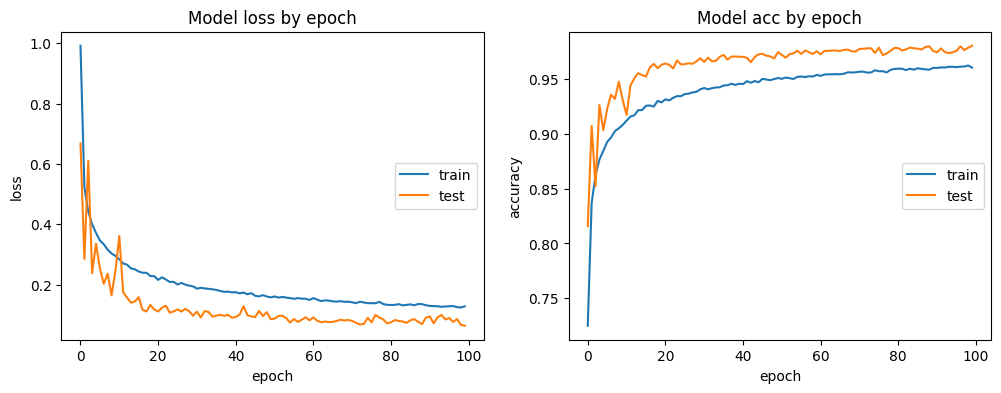

In [ ]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(df)

In [45]:
import random
def process_batches(test_generator):
  """
     Gets the predictions using model_resnet on the batches of a generator, the
     true labels and the images.

    :param test_generator: takes in a generator
  """
  predictions = []
  true_y = []
  X_test = []
  batch_index = 0

  while batch_index <= test_data.batch_index:
      batch = test_generator.next()
      x_batch, y_batch = batch
      pred = model_resnet.predict(x_batch)
      predictions.append(pred)
      true_y.append(y_batch)
      X_test.append(x_batch)
      batch_index = batch_index + 1
  return (predictions, true_y, X_test)



In [46]:
import tensorflow as tf

# Load model 
model_path = '/content/drive/MyDrive/Plants/model/resnet_disease'
model_resnet = tf.keras.models.load_model(model_path)

In [47]:
# Fetching real labels and prediction
y_pred_model_resnet, y_true, X_test = process_batches(test_data)

2/2 [==============================] - 1s 14ms/step


In [48]:
# Getting the results as arrays
y_true = np.concatenate(y_true, axis=0)
y_pred_model_resnet = np.concatenate(y_pred_model_resnet, axis=0)
X_test = np.concatenate(X_test, axis=0)

In [ ]:
# Checking that the shape is correct
X_test.shape 

(17572, 224, 224, 3)

In [49]:
# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_resnet, axis=1)

# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       504
         1.0       1.00      0.99      0.99       497
         2.0       1.00      1.00      1.00       440
         3.0       0.96      1.00      0.98       502
         4.0       1.00      0.99      1.00       454
         5.0       1.00      1.00      1.00       421
         6.0       1.00      1.00      1.00       456
         7.0       0.92      0.96      0.94       410
         8.0       0.99      1.00      0.99       477
         9.0       0.97      0.92      0.94       477
        10.0       1.00      1.00      1.00       465
        11.0       0.99      0.98      0.98       472
        12.0       0.98      0.99      0.98       480
        13.0       1.00      1.00      1.00       430
        14.0       1.00      1.00      1.00       423
        15.0       1.00      1.00      1.00       503
        16.0       1.00      0.99      1.00       459
        17.0       0.99    

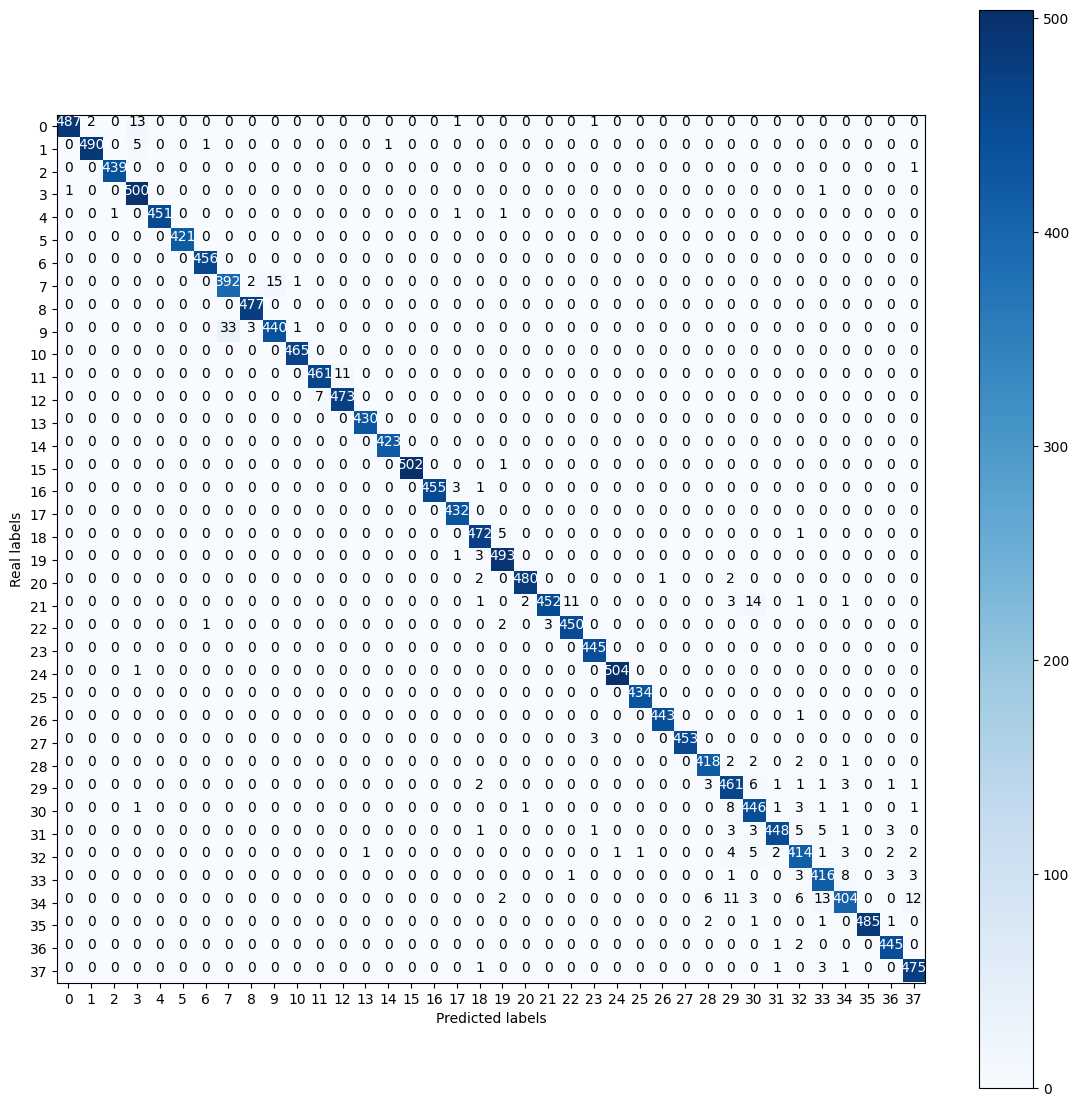

In [50]:
# Confusion matrix
plot_cm(y_true, y_pred)

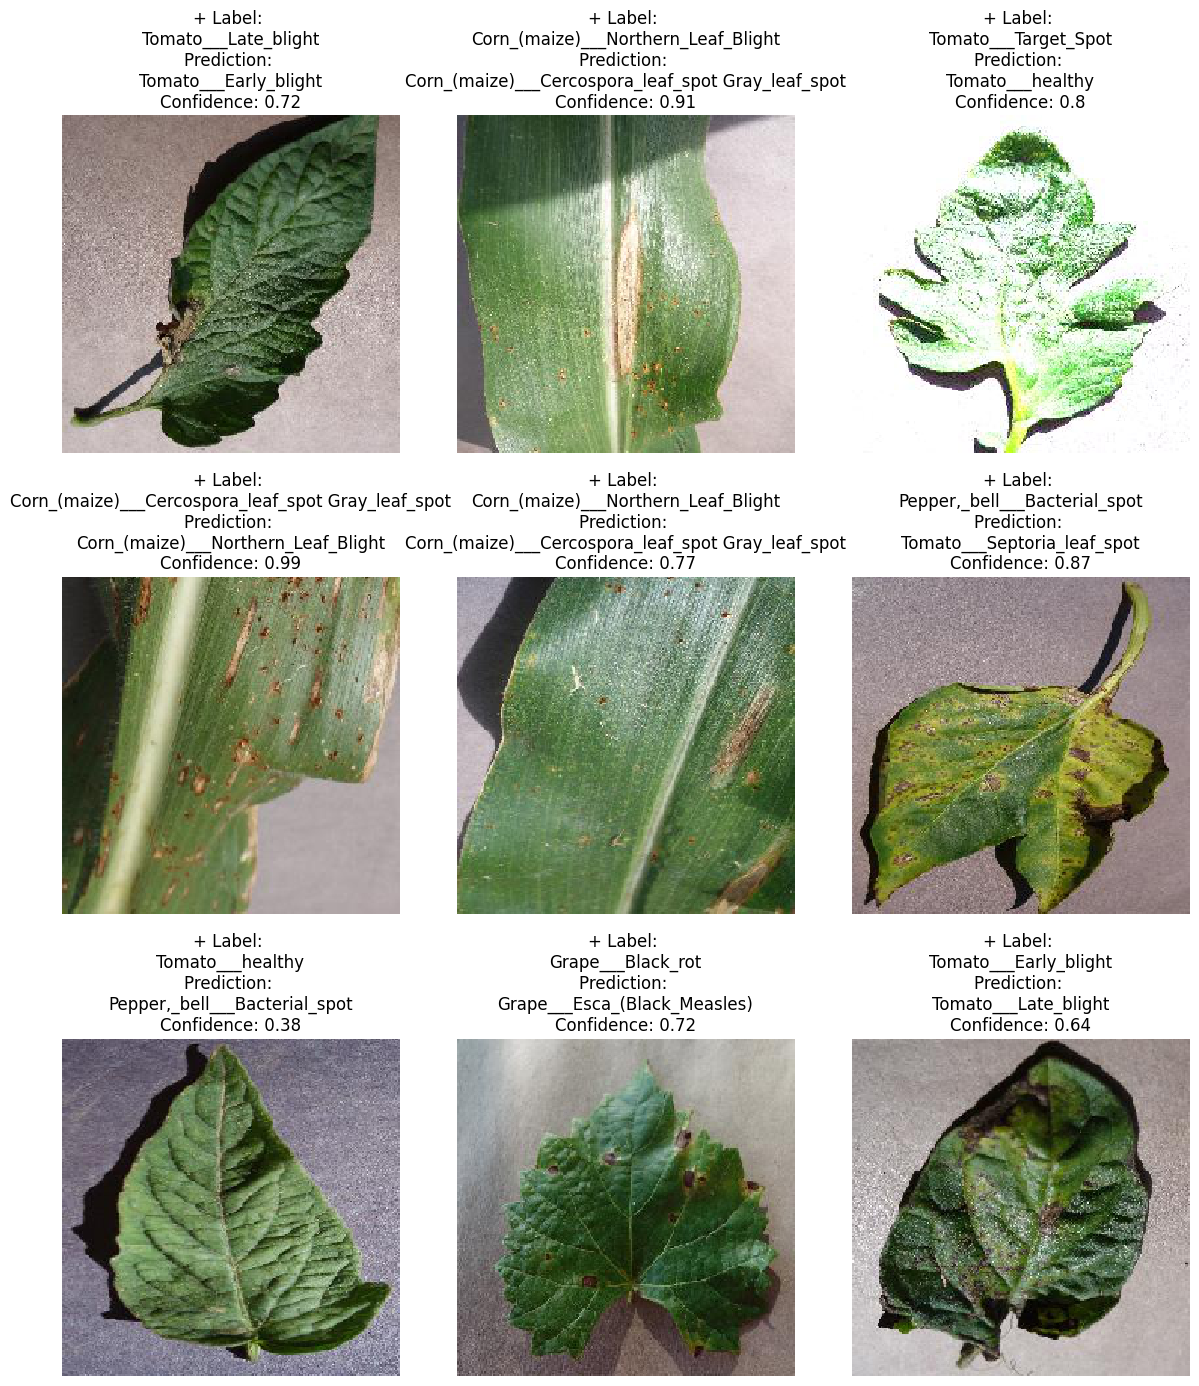

In [51]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_resnet, y_pred, X_test, y_true)